In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
from copy import deepcopy

In [33]:
RUN_BASELINE_ONLY = False
image_mode = False
debug_mode = False

drop_percentages = [0.1, 0.3, 0.5, 0.7]
number_of_generated_subgraphs = 100
baseline_file = "experiment_3"

In [34]:
results = {}
nodes_results = {} 
baseline_success = None

In [35]:
for i, drop_pct in enumerate(drop_percentages):
    # The baseline does not change since there are no nodes dropped
    # so i wait for the first iteration to finish to create the first basline.log file
    # then i extract the baseline from that logfile once and let the iterations finish
    if i == 1:
        if os.path.exists(baseline_file+'.log'):
            with open(baseline_file+'.log', 'r') as f:
                content = f.read()
            baseline_match = re.search(r'Attacker can guarantee success probability of: ([0-9.]+)', content)
            if baseline_match:
                baseline_success = float(baseline_match.group(1))
            print(f"Baseline attacker success: {baseline_success}")

    print(f"\n{'='*50}")
    print(f"RUNNING EXPERIMENT WITH DROP PERCENTAGE: {drop_pct*100}%")
    print(f"{'='*50}\n")
    
    # Set variables that will be accessible in the experiment notebook
    experiment_name = f"experiment_drop_{int(drop_pct*100)}"
    
    # Set the drop hyperpar. and run the experiment
    # extrapol_pct = drop_pct
    # this will run the experiment file
    # which in turn will run 1) subgraph generation 2) ctr-core
    %run "{baseline_file}.ipynb"
    
    # Extract average success from subgraph analysis
    subgraph_file = f"sub_{baseline_file}.log"
    if os.path.exists(subgraph_file):
        with open(subgraph_file, 'r') as f:
            content = f.read()
        avg_match = re.search(r'Average attacker success across subgraphs: ([0-9.]+)', content)
        nodes_match = re.search(r'Number of dropped nodes per subgraph: ([0-9]+)', content)

        if avg_match:
            avg_success = float(avg_match.group(1))
            #results[drop_pct] = avg_success
            results[drop_pct] = round(avg_success, 3)
            diff = avg_success - baseline_success if baseline_success else "N/A"
            print(f"Drop %: {drop_pct*100}%, Avg Success: {avg_success}, Diff: {diff}")

        if nodes_match:
            dropped_nodes = int(nodes_match.group(1))
            nodes_results[drop_pct] = dropped_nodes
            print(f"Number of dropped nodes per subgraph: {dropped_nodes}")

    else:
        print(f"Warning: Could not find subgraph log file")


RUNNING EXPERIMENT WITH DROP PERCENTAGE: 10.0%

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports
Current settings: image_mode=False, debug_mode=False, RUN_BASELINE_ONLY=False
create subsgraph for defender concluded
We start with the baseline graph calculation!
Now we are going to run the subgraph analysis
The subgraph analysis is done!
[1] "experiment_3.log"
[1] "Sun Mar 23 14:29:14 2025"



BASELINE RUN: BOTH ATTACKER AND DEFENDER HAVE FULL GRAPH KNOWLEDGE



++++++++++++++++++++++++++++++++

The virtual target nodeID is c(12,13,14,16)

attack rate =  0 , defense rate =  0 

	equilibrium for multiobjective security game (MOSG)

optimal defense strategy:
         prob.
1 0.000000e+00
10 0.000000e+00
11 2.720264e-01
15 1.852234e-01
2 0.000000e+00
3 0.000000e+00
4 0.000000e+00
5 0.000000e+00
6 0.000000e+00
7 0.000000e+00
8 5.427503e-01
9 0.000000e+00

worst case attack strategies per goal:
          1


In [36]:
# Create DataFrame
df = pd.DataFrame({
    'Drop Percentage': [k*100 for k in results.keys()],
    'dropped_nodes': [nodes_results[k] for k in results.keys()],  # Convert to list in the same order
    'Average Success': list(results.values()),
    'Baseline': [baseline_success] * len(results),
    'Difference': [results[k] - baseline_success for k in results.keys()]
})

# Print dataframe here to read
# Store it in some external .csv file for potential later use
print("\nFinal Results:")
print(df)
df.to_csv(f'{baseline_file}_extrapolation_results.csv', index=False)


Final Results:
   Drop Percentage  dropped_nodes  Average Success  Baseline  Difference
0             10.0              1            0.104     0.089       0.015
1             30.0              3            0.142     0.089       0.053
2             50.0              6            0.168     0.089       0.079
3             70.0              8            0.181     0.089       0.092


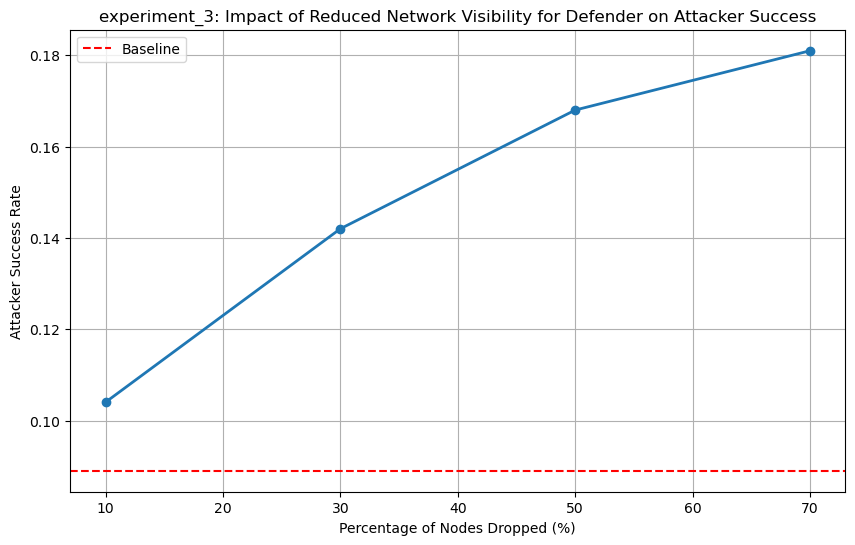

In [40]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df['Drop Percentage'], df['Average Success'], 'o-', linewidth=2)
plt.axhline(y=baseline_success, color='r', linestyle='--', label='Baseline')
plt.xlabel('Percentage of Nodes Dropped (%)')
plt.ylabel('Attacker Success Rate')
plt.title(f'{baseline_file}: Impact of Reduced Network Visibility for Defender on Attacker Success')
plt.legend()
plt.grid(True)
plt.savefig(f'{baseline_file}_plot.png')
plt.show()